<a href="https://colab.research.google.com/github/anilans029/insurance_premium_prediction/blob/main/insrance_premium_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement:**
*The goal of this project is to give people an estimate of how much they need based on their individual health situation. After that, customers can work with any health insurance carrier and its plans and perks while keeping the projected cost from our study in mind. This can assist a person in concentrating on the health side of an insurance policy rather han the ineffective part.*

# **Dataset description:**
**1. Age:** Person's age in years 

**2. Sex:** Gender of the person or insurance holder(Female or Male)

**3. BMI:** Body mass index. The ideal range according to height and weight is 18.5 to 24.9

**4. Children:** Number of dependents

**5. Smoker:** Whether the insurance holder smokes or not

**6. Region:** Residential area of the person

**7. Expenses:** Individual medical costs billed by health insurance

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline,Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

# to display the pipeline
from sklearn import set_config
set_config(display='diagram')

In [2]:
df = pd.read_csv("/content/insurance.csv")
print("the shape of the dataset is : ",df.shape, "\n")
print(df.head())

the shape of the dataset is :  (1338, 7) 

   age     sex   bmi  children smoker     region  expenses
0   19  female  27.9         0    yes  southwest  16884.92
1   18    male  33.8         1     no  southeast   1725.55
2   28    male  33.0         3     no  southeast   4449.46
3   33    male  22.7         0     no  northwest  21984.47
4   32    male  28.9         0     no  northwest   3866.86


# ***Exploring the data***

In [3]:
## statistical information of the data

df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.00,27.0000,39.00,51.000,64.00
bmi,1338.0,30.665471,6.098382,16.00,26.3000,30.40,34.700,53.10
children,1338.0,1.094918,1.205493,0.00,0.0000,1.00,2.000,5.00
expenses,1338.0,13270.422414,12110.011240,1121.87,4740.2875,9382.03,16639.915,63770.43


In [4]:
df.describe(include="O").T

,count,unique,top,freq
sex,1338,2,male,676
smoker,1338,2,no,1064
region,1338,4,southeast,364


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


## **Check for missing values**

In [6]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

### **Observation 1:**

>Dataset containing 1338 records

> numerical features = age, bmi, children, expenses

> categorical features = sex, smoker, region

> there are no missing values present in the dataset




## **Check for duplicates**

In [7]:
df.duplicated().sum()

1

In [8]:
df.drop_duplicates(inplace = True)

## **Univariate Analysis**

In [9]:
data = df.copy()
data.head(2)

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55


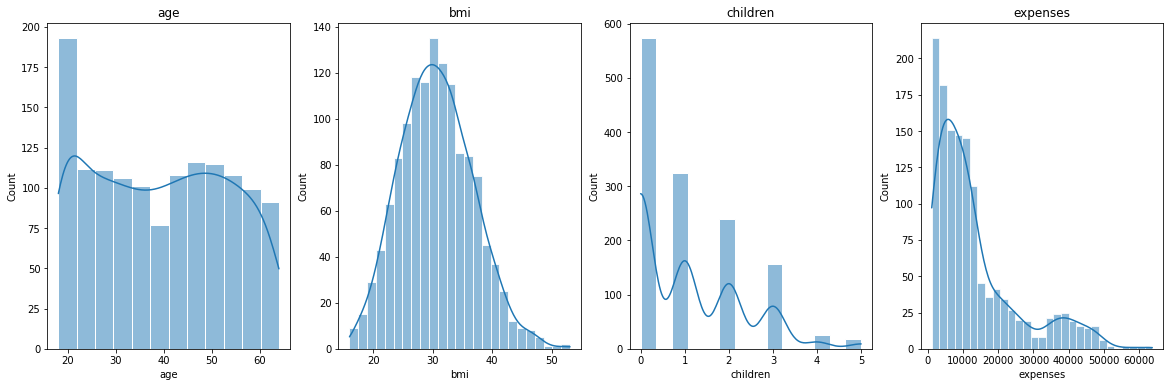

In [10]:
fig, axes = plt.subplots(1,4)   
axes = axes.flatten()        
fig.set_size_inches(20,6)
num_col = [col for col in data.columns if data[col].dtype!="O"]

for ax, col in zip(axes,num_col):
  sns.set_style("darkgrid", {"axes.facecolor": ".9"})
  sns.histplot(data[col], ax = ax,kde= True)
  ax.set_title(col)

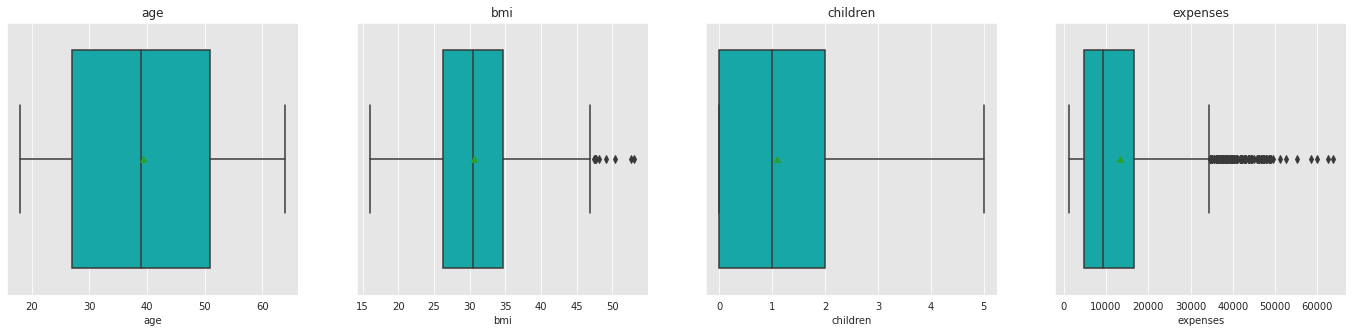

In [11]:
fig, axes = plt.subplots(1,4)   
axes = axes.flatten()        
fig.set_size_inches(24,5)
num_col = [col for col in data.columns if data[col].dtype!="O"]

for ax, col in zip(axes,num_col):
  sns.set_style("darkgrid", {"axes.facecolor": ".9"})
  sns.boxplot(data[col], ax = ax,showmeans=True,color= 'c')
  ax.set_title(col)

**Observation 2 :**

1. Age: It is following almost uniform distribution and it seems like there are more customers of age b/w 18 to 20

2. BMI : it is following normal distribution and approximately mean = 30. And there are few outliers present in this feature

3. Expenses: we can observe this variable is following power law distrubution and highly right skewed.  Also, for most customers, the annual medical expenses are under 10k. Only a small fraction of customer have higher medical expenses, possibly due to accidents, major illnesses and genetic diseases.


### ***region, sex***

southeast    364
southwest    325
northwest    324
northeast    324
Name: region, dtype: int64  /n/n


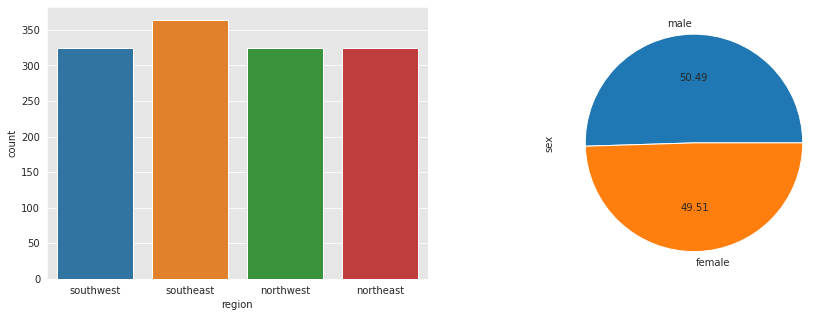

In [12]:
print(data["region"].value_counts(),' /n/n')

fig, axes = plt.subplots(1,2)   
axes = axes.flatten()        
fig.set_size_inches(15,5)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.countplot(ax= axes[0], data = data, x="region")
data["sex"].value_counts().plot(kind='pie',autopct= "%.2f")

observation 3:

> the dataset is having almost same no.of males and females

> Also, the no.of customers per region are almost same

### ***smoker vs sex***

no     1063
yes     274
Name: smoker, dtype: int64


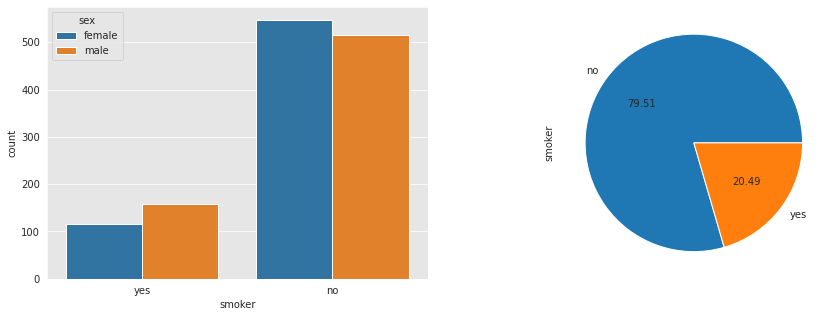

In [13]:
print(data["smoker"].value_counts())

fig, axes = plt.subplots(1,2)   
axes = axes.flatten()        
fig.set_size_inches(15,5)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.countplot(ax= axes[0], data = data, x="smoker",hue= 'sex')
data["smoker"].value_counts().plot(kind='pie',autopct= "%.2f")

### ***observation 4:***

It shows that only 20% of the customers are having smoking habit.

We can also see that smoking appears a more common habit among males.


## **Bi-variate analysis**

## ***expenses vs numerical features***

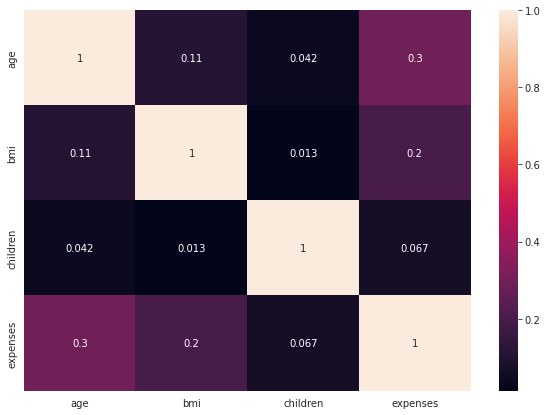

In [14]:
plt.figure(figsize= (10,7))
corr = data.corr()
ax = sns.heatmap(corr,annot=True)

> we can see age and bmi are having more correlation to expenses

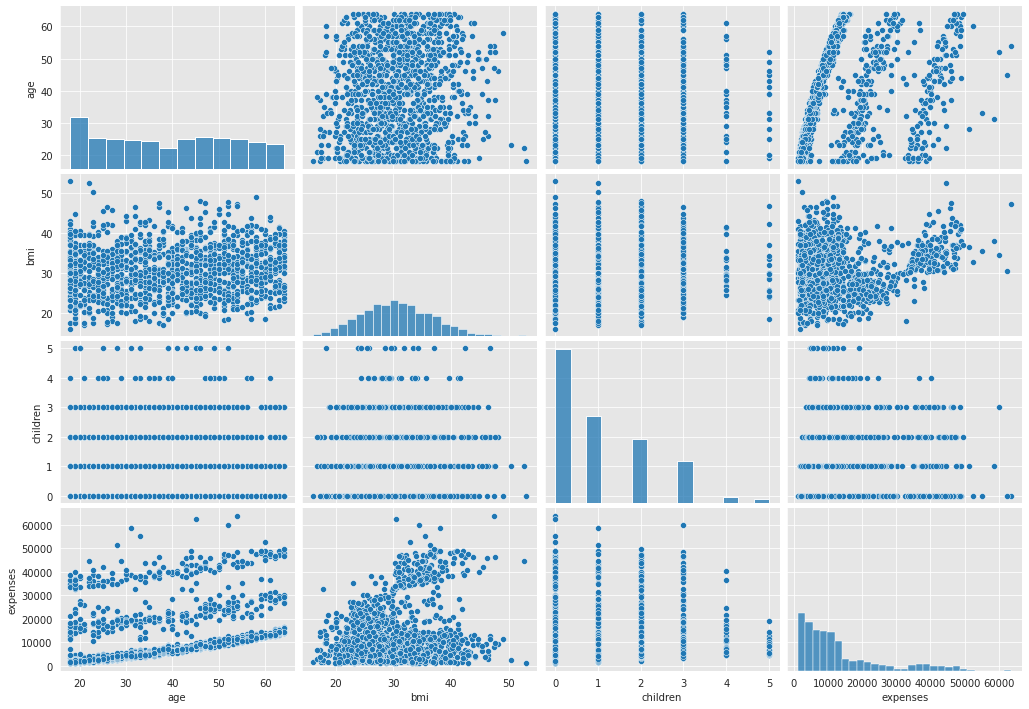

In [15]:
figure = sns.pairplot(data)
figure.fig.set_size_inches(15,10)

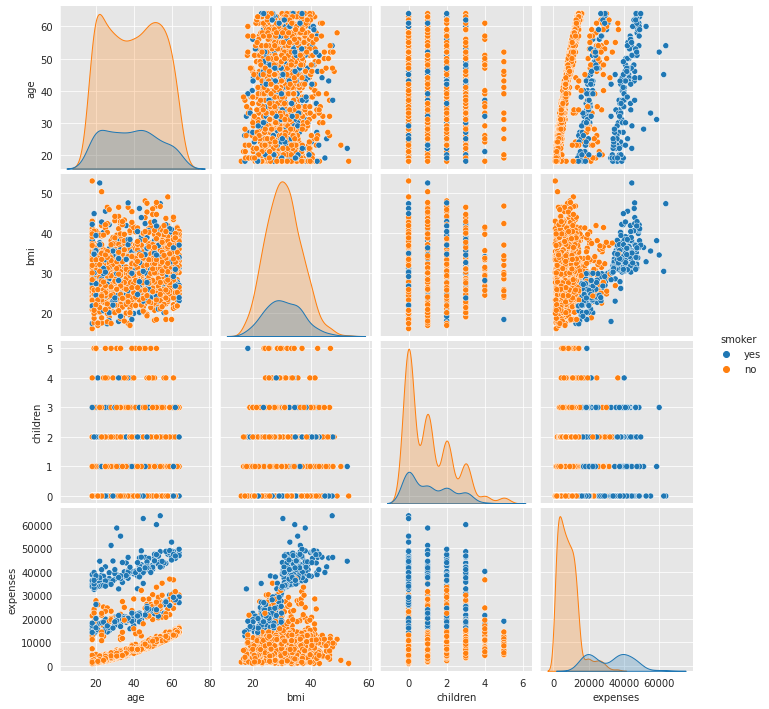

In [16]:

sns.pairplot(data,hue = 'smoker')


### **Bmi vs Expenses w.r.t smoker**

Text(0.5, 1.0, 'age vs expenses')

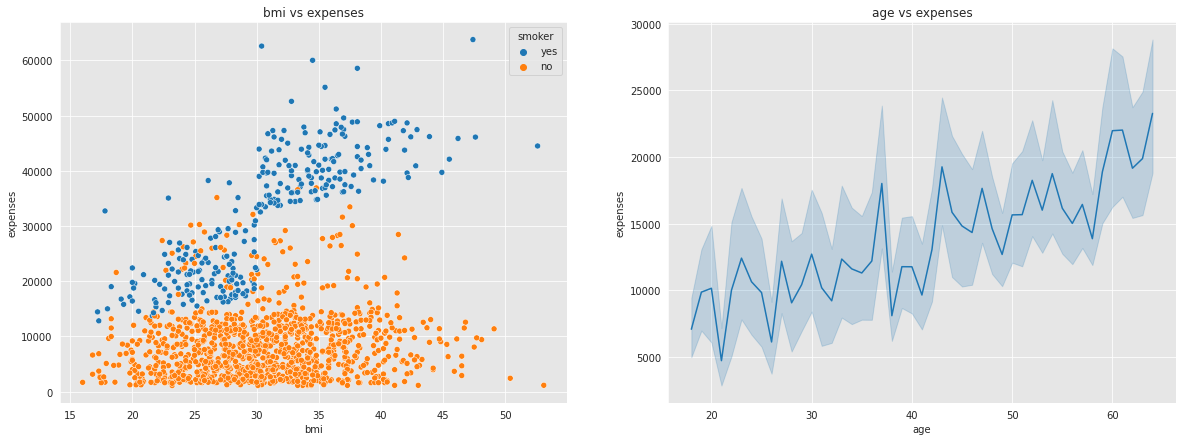

In [17]:
fig, axes = plt.subplots(1,2)   
axes = axes.flatten()        
fig.set_size_inches(20,7)
sns.scatterplot(df["bmi"],data["expenses"],ax=axes[0],hue=data["smoker"])
axes[0].set_title("bmi vs expenses")
sns.lineplot(data["age"],data["expenses"],ax=axes[1])
axes[1].set_title("age vs expenses")

observation :

1. we can observe here that person who has more bmi and also having smoking habit is paying more expenses

2. And the person with lesser are having less expenses when compared to person with more age

In [18]:
data.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'expenses'], dtype='object')

### **categorical_features vs expenses**

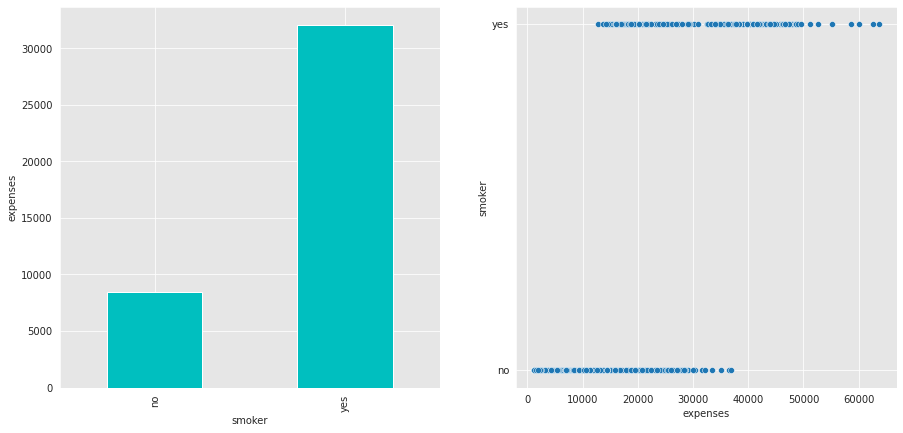

In [19]:
fig, ax =plt.subplots(1,2)
ax = ax.flatten()
fig.set_size_inches(15,7)

data.groupby("smoker")['expenses'].mean().plot(ax= ax[0],ylabel="expenses", kind= 'bar',color='c')
sns.scatterplot(data["expenses"],data["smoker"],ax = ax[1])

observation:

> we can see here that when a customer is having smoking habit, the expenses are high

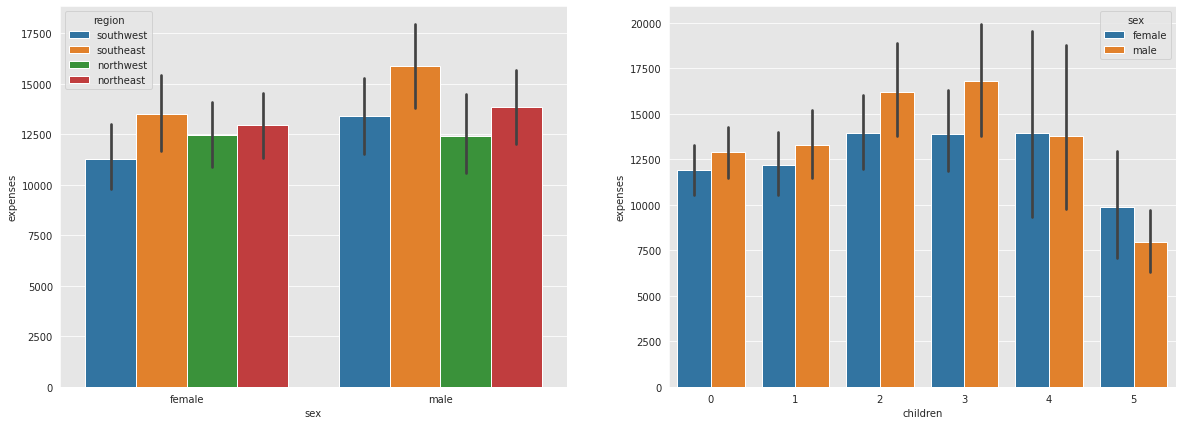

In [20]:
fig, ax =plt.subplots(1,2)
ax = ax.flatten()
fig.set_size_inches(20,7)

sns.barplot(x = "sex", y = "expenses",hue='region', data = data,ax = ax[0])
sns.barplot(x = "children", y = "expenses",hue='sex', data = data, ax= ax[1])


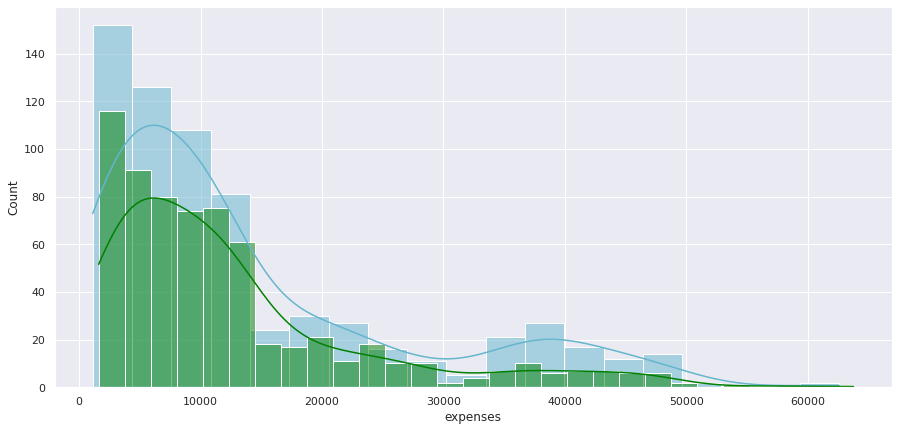

In [21]:
male = data[data["sex"]=='male']
female = data[data["sex"]=='female']

sns.set(rc = {'figure.figsize':(15,7)})
sns.histplot(male['expenses'],color= 'c',kde= True)
sns.histplot(female['expenses'],color= 'green',kde=True)



> we can observe a significant changes in the expenses between male and female customers and also the expense of male customer is high in most of the data

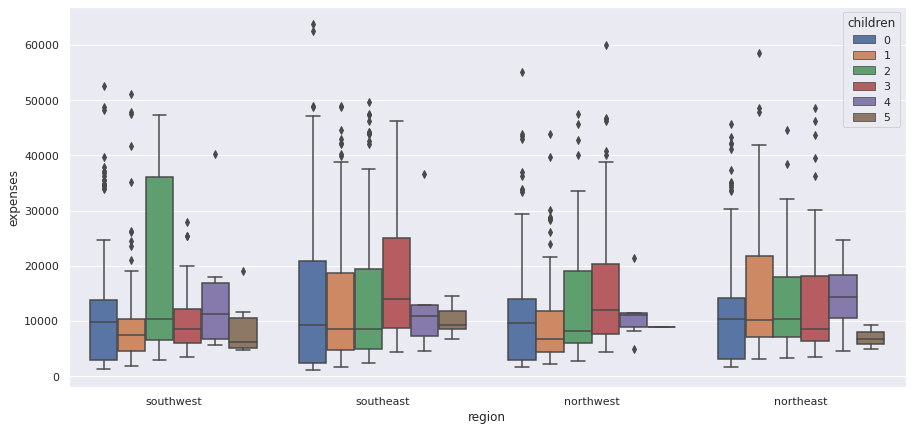

In [22]:
sns.boxplot(x='region',y='expenses',hue = 'children',data=data)

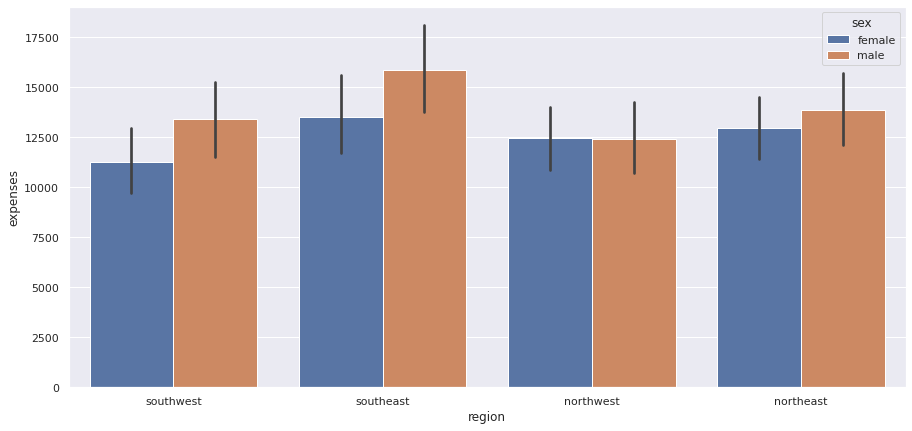

In [23]:
sns.barplot(x = "region", y = "expenses",hue='sex', data = df)

## **Handling outlier in bmi**

In [24]:
## this function perform imputaion with the mean of the variable where outliers are present

def detect_outlier(df,variable_name):
  outliers = []
  q1 = data["bmi"].quantile(0.25)
  q3 =data["bmi"].quantile(0.75)

  iqr = q3 - q1
  upper_fence = q3+ 1.5*iqr
  lower_fence = q1 - 1.5*iqr
  variable_mean = np.mean(df[variable_name])

  df[variable_name] = df[variable_name].apply(lambda x: variable_mean if(x<lower_fence or x>upper_fence) else x)
  return df
  

Text(0.5, 1.0, 'after imputing outliers')

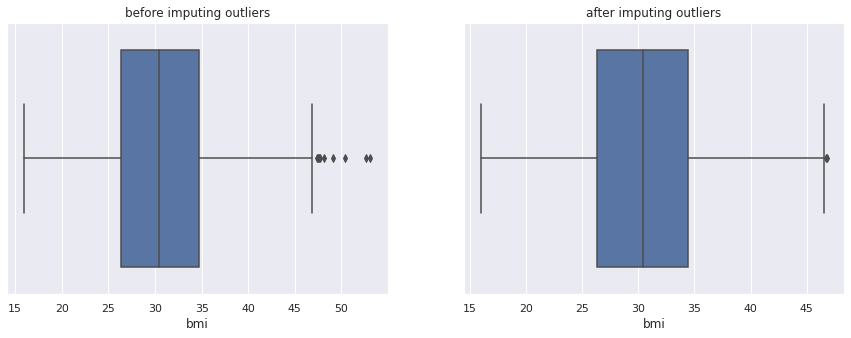

In [25]:
fig, ax =plt.subplots(1,2)
ax = ax.flatten()
fig.set_size_inches(15,5)

sns.boxplot(data["bmi"],ax = ax[0])
ax[0].set_title("before imputing outliers")
data = detect_outlier(data,'bmi')
sns.boxplot(data["bmi"],ax = ax[1])
ax[1].set_title("after imputing outliers")


### **Seperating numerical and categorical columns**

In [26]:
### seperating dependent and independent features 

x,y = data.drop(columns = ["expenses"]), data['expenses']
print(x.shape)
print(y.shape)

(1337, 6)
(1337,)


In [27]:
cat_col=[]
num_col = []
[cat_col.append(col) if x[col].dtype=="O" else num_col.append(col) for col in x.columns]
print(cat_col)
print(num_col)

['sex', 'smoker', 'region']
['age', 'bmi', 'children']


**Splitting the data into train and test**

In [28]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.25,random_state =35)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape,y_test.shape)

(1002, 6)
(1002,)
(335, 6) (335,)


In [29]:
x_train.head(3)

,age,sex,bmi,children,smoker,region
812,54,male,21.0,2,no,southeast
548,25,female,28.6,0,no,northeast
1277,32,female,29.7,0,no,northwest


# **creating a pipelines**

***creating column transformers for the preprocessing of the data***

In [30]:
## transformer function for the encoding of the categorical variables using onehotencoding
categorical_encoding = OneHotEncoder(sparse=False,handle_unknown='ignore',drop='first')


### transformer funciton for the scaling of the numerical variables using standard scaler
numerical_scaling = StandardScaler()

data_preprocessing = ColumnTransformer(transformers=[
                              ('encoding', categorical_encoding, cat_col),
                              ('scaling', numerical_scaling, num_col)
                            ], remainder='passthrough')

***creating pipelines with same preprocessing steps but different regressor algorithms***

In [123]:
pipe_lr = Pipeline([ ("preprocessing",data_preprocessing),("regressor", LinearRegression()) ])
pipe_dt = Pipeline([("preprocessing",data_preprocessing),('regressor', DecisionTreeRegressor())])
pipe_knn = Pipeline([("preprocessing",data_preprocessing),('regressor',KNeighborsRegressor(n_neighbors=7))])
pipe_rf = Pipeline([("preprocessing",data_preprocessing),('regressor',RandomForestRegressor())])
pipe_gb = Pipeline([("preprocessing",data_preprocessing),('regressor', GradientBoostingRegressor())])
pipe_xgb  = Pipeline([("preprocessing",data_preprocessing),('regressor', XGBRegressor())])
pipelines = [pipe_lr, pipe_dt, pipe_knn, pipe_rf, pipe_gb,pipe_xgb]

pipes_dict = {0: "linear_reg",1:"Decision_tree_reg",2:"Knn_regressor",3:"Random_forest_reg",4: "Gradient_Boosting_Regressor",5:"XGB_Regressor"}

**Without performing Hyperparameter tuning**

In [133]:
for idx, pipe in enumerate(pipelines):
  pipe.fit(x_train,y_train)
  print(f" the test accuracy score for the {pipes_dict[idx]} is :    {pipe.score(x_test,y_test)}")

 the test accuracy score for the linear_reg is :    0.7384456657712792
 the test accuracy score for the Decision_tree_reg is :    0.7495977973344566
 the test accuracy score for the Knn_regressor is :    0.6804315770502389
 the test accuracy score for the Random_forest_reg is :    0.8469957962731507
 the test accuracy score for the Gradient_Boosting_Regressor is :    0.8520103847661453
[14:57:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
 the test accuracy score for the XGB_Regressor is :    0.8513840116697415


***using GridsearchCV***

In [38]:
params_D_Tree = {
              "regressor": [DecisionTreeRegressor()],
              "regressor__splitter":["best", "random"],
              "regressor__max_depth" : list(range(1,13)),
              "regressor__min_samples_leaf":list(range(1,13)),
              "regressor__min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
              "regressor__max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] 
}

grid_search_DT = GridSearchCV(pipe_dt,param_grid= params_D_Tree,cv=5, verbose = 0, n_jobs = -1)
grid_search_DT.fit(x_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('encoding',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region']),
                                                                        ('scaling',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children'])])),
                                       ('regressor', DecisionTreeRegressor())]),
             n_jobs=-1,
             param_grid={'regressor...
                                                  'absolute_error', 'poisson'],
                         'regressor__max_depth': [1, 3, 5, 7, 9, 11, 12],
                         'regressor__max_features': ['auto', 'log2', 'sqrt',
                                                     None],
                         'regressor__max_leaf_nodes': [None, 10, 20, 30, 40, 50,
                                                       60, 70, 80, 90],
                         'regressor__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10],
                         'regressor__min_weight_fraction_leaf': [0.1, 0.2, 0.3,
                                                                 0.4, 0.5, 0.6,
                                                                 0.7, 0.8,
                                                                 0.9],
                         'regressor__splitter': ['best', 'random']})

In [39]:
grid_param_KNN = {
          "regressor": [KNeighborsRegressor()],
          "regressor__leaf_size":list(range(1,50)),
          "regressor__n_neighbors":list(range(1,30)),
          "regressor__p":[1,2]
}
grid_search_KNN = GridSearchCV(pipe_knn,param_grid= grid_param_KNN,cv=5, verbose = 0, n_jobs = -1)
grid_search_KNN.fit(x_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('encoding',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region']),
                                                                        ('scaling',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children'])])),
                                       ('regressor',
                                        KNeighborsRegressor(n_neighbors=7))]),
             n_jobs=-1,
             param_grid={'regressor': [KNeighborsRegressor(leaf_size=7,
                                                           n_neighbors=3,
                                                           p=1)],
                         'regressor__leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                  11, 12, 13, 14, 15, 16, 17,
                                                  18, 19, 20, 21, 22, 23, 24,
                                                  25, 26, 27, 28, 29, 30, ...],
                         'regressor__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                    10, 11, 12, 13, 14, 15, 16,
                                                    17, 18, 19, 20, 21, 22, 23,
                                                    24, 25, 26, 27, 28, 29],
                         'regressor__p': [1, 2]})

In [73]:
grid_param_RF ={"regressor": [RandomForestRegressor()],
                 "regressor__n_estimators":[50,100,200,400], 
                 "regressor__max_depth":[2,4,5,7,9],
                 "regressor__random_state":[13]}

grid_search_RF = GridSearchCV(pipe_rf,param_grid= grid_param_RF,cv=5, verbose = 0, n_jobs = -1)
grid_search_RF.fit(x_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('encoding',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region']),
                                                                        ('scaling',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children'])])),
                                       ('regressor', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'regressor': [RandomForestRegressor(max_depth=4,
                                                             n_estimators=200,
                                                             random_state=13)],
                         'regressor__max_depth': [2, 4, 5, 7, 9],
                         'regressor__n_estimators': [50, 100, 200, 400],
                         'regressor__random_state': [13]})

In [72]:
grid_param_GB = {
          "regressor": [GradientBoostingRegressor()],
          'regressor__n_estimators' : [10, 50, 100, 500],
          'regressor__learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1.0],
          'regressor__subsample' : [0.5, 0.7, 1.0],
          'regressor__max_depth' : [3, 7, 9]
          }
grid_search_GB = GridSearchCV(pipe_gb,param_grid= grid_param_GB,cv=5, verbose = 0, n_jobs = -1)
grid_search_GB.fit(x_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('encoding',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region']),
                                                                        ('scaling',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children'])])),
                                       ('regressor',
                                        GradientBoostingRegressor())]),
             n_jobs=-1,
             param_grid={'regressor': [GradientBoostingRegressor(learning_rate=0.01,
                                                                 n_estimators=500,
                                                                 subsample=0.7)],
                         'regressor__learning_rate': [0.0001, 0.001, 0.01, 0.1,
                                                      1.0],
                         'regressor__max_depth': [3, 7, 9],
                         'regressor__n_estimators': [10, 50, 100, 500],
                         'regressor__subsample': [0.5, 0.7, 1.0]})

In [128]:
grid_param_XGB = {
              "regressor":[XGBRegressor()],
              "regressor__max_depth":    [3, 7, 9, 4, 5],
              "regressor__n_estimators": [500, 600, 700],
              "regressor__learning_rate": [0.01, 0.015,0.0001, 0.001, 0.1, 1.0],
              'regressor__subsample' : [0.5, 0.7, 1.0],

}

grid_search_XGB = GridSearchCV(pipe_xgb,param_grid= grid_param_XGB,cv=5, verbose = 0, n_jobs = -1)
grid_search_XGB.fit(x_train,y_train)

[14:52:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('encoding',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region']),
                                                                        ('scaling',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children'])])),
                                       ('regressor', XGBRegressor())]),
             n_jobs=-1,
             param_grid={'regressor': [XGBRegressor(learning_rate=0.01,
                                                    n_estimators=500,
                                                    subsample=1.0)],
                         'regressor__learning_rate': [0.01, 0.015, 0.0001,
                                                      0.001, 0.1, 1.0],
                         'regressor__max_depth': [3, 7, 9, 4, 5],
                         'regressor__n_estimators': [500, 600, 700],
                         'regressor__subsample': [0.5, 0.7, 1.0]})

In [129]:

print(f"the test accuraccy score of Decision_tree before = {pipe_dt.score(x_test,y_test)} , and after using GridSearchCV = {grid_search_DT.score(x_test,y_test)} ")
print(f"the test accuraccy score of KNN_regressor befor =  {pipe_knn.score(x_test,y_test)} , and after using GridSearchCV = {grid_search_KNN.score(x_test,y_test)} ")
print(f"the test accuraccy score of RandomForest_regressor before = {pipe_rf.score(x_test,y_test)} , and after using GridSearchCV = {grid_search_RF.score(x_test,y_test)} ")
print(f"the test accuraccy score of GradientBoosting_regressor before = {pipe_gb.score(x_test,y_test)} , and after using GridSearchCV = {grid_search_GB.score(x_test,y_test)} ")
print(f"the test accuraccy score of XGBoost_regressor before = {pipe_xgb.score(x_test,y_test)} , and after using GridSearchCV = {grid_search_GB.score(x_test,y_test)} ")

the test accuraccy score of Decision_tree before = 0.7524808750237832 , and after using GridSearchCV = 0.6762788565042572 
the test accuraccy score of KNN_regressor befor =  0.6235793675514612 , and after using GridSearchCV = 0.6804315770502389 
the test accuraccy score of RandomForest_regressor before = 0.8314360453616263 , and after using GridSearchCV = 0.8469957962731507 
the test accuraccy score of GradientBoosting_regressor before = 0.8519026246950767 , and after using GridSearchCV = 0.8520183764973109 
the test accuraccy score of XGBoost_regressor before = 0.8507898512723902 , and after using GridSearchCV = 0.8513840116697415 


Observation:

1. here after using GridsearchCV with different params, there is slight increase in the accuracy of the RandomForest_regressor, GradientBoosting_regressor, XGB_regressor, KNN_regressor. so lets use those params in our pipeline

2. But the accuracy of the Decision Tree got reduced

## ***Updating the pipelines with best params***

In [130]:
grid_search_XGB.best_params_

{'regressor': XGBRegressor(learning_rate=0.01, n_estimators=500, subsample=1.0),
 'regressor__learning_rate': 0.01,
 'regressor__max_depth': 3,
 'regressor__n_estimators': 500,
 'regressor__subsample': 1.0}

In [131]:
pipe_lr = Pipeline([ ("preprocessing",data_preprocessing),("regressor", LinearRegression()) ])
pipe_dt = Pipeline([("preprocessing",data_preprocessing),('regressor', DecisionTreeRegressor())])
pipe_knn = Pipeline([("preprocessing",data_preprocessing),('regressor',KNeighborsRegressor(leaf_size=7, n_neighbors=3, p=1))])
pipe_rf = Pipeline([("preprocessing",data_preprocessing),('regressor',RandomForestRegressor(max_depth=4, n_estimators=200, random_state=13))])
pipe_gb = Pipeline([("preprocessing",data_preprocessing),('regressor', GradientBoostingRegressor(learning_rate=0.01, n_estimators=500, subsample=0.7))])
pipe_xgb  = Pipeline([("preprocessing",data_preprocessing),('regressor', XGBRegressor(learning_rate=0.01, n_estimators=500, subsample=1.0))])
pipelines = [pipe_lr, pipe_dt, pipe_knn, pipe_rf, pipe_gb,pipe_xgb]

pipes_dict = {0: "linear_reg",1:"Decision_tree_reg",2:"Knn_regressor",3:"Random_forest_reg",4: "Gradient_Boosting_Regressor",5:"XGB_Regressor"}

## ***Evaluating the metrics for all the models***

In [98]:
### function to calculate the evaluation metrics

def evaluate_model(model,y_actual,y_pred):
  
  model_metrics = pd.DataFrame({"model_name":[model],
                "mse" : [np.round(mean_squared_error(y_actual,y_pred),4)],
                "rmse" : [np.sqrt(mean_squared_error(y_actual,y_pred))],
                "mae" : [mean_absolute_error(y_actual,y_pred)],
                "r2" : [r2_score(y_actual,y_pred)]
  })
  return model_metrics

In [135]:
metrics_df = pd.DataFrame()

for idx, pipe in enumerate(pipelines):
  model = pipes_dict[idx]
  y_pred= pipe.predict(x_test)
  metrics = evaluate_model(model, y_test,y_pred)
  metrics_df = metrics_df.append(metrics, ignore_index=True)

In [136]:
metrics_df.sort_values(by= 'r2',ascending=False)

,model_name,mse,rmse,mae,r2
4,Gradient_Boosting_Regressor,2.316710e+07,4813.221144,2609.600792,0.852010
5,XGB_Regressor,2.326515e+07,4823.396482,2550.866240,0.851384
3,Random_forest_reg,2.395211e+07,4894.089158,2713.846060,0.846996
1,Decision_tree_reg,3.919932e+07,6260.936048,2884.042567,0.749598
0,linear_reg,4.094514e+07,6398.838599,4322.646491,0.738446
2,Knn_regressor,5.002698e+07,7072.975033,4131.741244,0.680432


### ***Gradinet_boostin_regressor is giving the best performance based on the metrics***

### ***export the pipe_gb as pkl file and loading it again to predict***

In [139]:
### exporting the GB_regressor pipeline pickle file 
pickle.dump(pipe_gb,open('pipe_gb.pkl','wb'))

In [144]:
## loading the pickle file 

with open('pipe_gb.pkl',"rb") as file:
  pipe = pickle.load(file)
pipe.fit(x_train,y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoding',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['sex', 'smoker', 'region']),
                                                 ('scaling', StandardScaler(),
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('regressor',
                 GradientBoostingRegressor(learning_rate=0.01, n_estimators=500,
                                           subsample=0.7))])

In [174]:
input = { "age" : [42],"sex" :["male"],"bmi":[37.2],"children":[2],"smoker": ["no"],   "region":["southeast"] }
ip = pd.DataFrame(input)
print("the predicted insurance premium : ",pipe_gb.predict(ip)[0])

the predicted insurance premium :  8318.350341034602
